# IMPORTS

In [1]:


import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

matplotlib.rcParams.update({'font.size': 14})


# PATHS

In [2]:
# Path for Prepared DataFrames

PREPARED_DATASET_PATH_FOR_TRAIN = './prepared_4_train.csv'

PREPARED_DATASET_PATH_FOR_TEST = './prepared_4_test.csv'

SAMPLE_SUBMISSION_PATH = './sample_submission.csv'

# WORKING WITH DATA

In [3]:
# Read Prepared DataFrames

train_df = pd.read_csv(PREPARED_DATASET_PATH_FOR_TRAIN, sep=',')
test_df = pd.read_csv(PREPARED_DATASET_PATH_FOR_TEST, sep=',')

In [4]:
# Split DataFrame 'train_df' into 2 parts:

# X contains all features of train_df, except feature 'Price'

X = train_df.drop(columns=['Price'])

# y contains feature 'Price' from train_df

y = train_df['Price']

# SPLIT (X, y) INTO TRAIN & VALID

In [5]:
# Use 33% from whole DataFrame

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=45)

In [6]:
# Check same Feature Qty

X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [7]:
# Check fro empty dataFields

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# BUILDING MODELS

In [8]:


rf_model = RandomForestRegressor(random_state=45, criterion='mse')
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=45)

In [9]:
# Function evaluate_preds - Display R2 results after using RandomForestRegressor

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    """Display R2 score"""
    
    train_R2_result = round(r2(train_true_values, train_pred_values), 3)
    test_R2_result = round(r2(test_true_values, test_pred_values), 3)
    
    print("Train R2:\t" + str(train_R2_result))
    print("Test R2:\t" + str(test_R2_result))
    print("Different:\t" + str(train_R2_result - test_R2_result))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()



Train R2:	0.96
Test R2:	0.734
Different:	0.22599999999999998


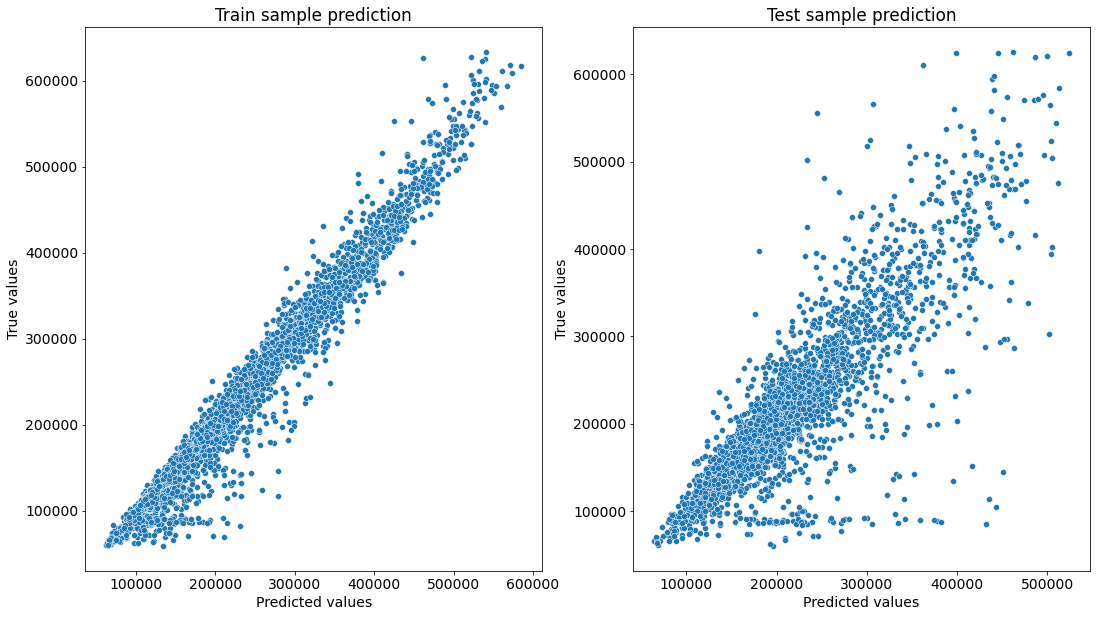

In [10]:


y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)



### Train R2:	0.96
### Test R2:	0.734
### Different:	0.22599999999999998

### Results of overteaching


# FIXING OVERTEACHING

In [11]:
# Display importance of features in DataFrame

feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.405831
8,Social_1,0.112555
9,Social_2,0.098651
10,Social_3,0.064723
0,Rooms,0.053523
7,Ecology_1,0.046181
6,HouseYear,0.041939
2,LifeSquare,0.032788
11,Healthcare_1,0.026779
3,KitchenSquare,0.025235


# USE GradientBoostingRegressor

In [12]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor

In [13]:
# Create Dict for results

scoreboard = {}

# Version 1

In [14]:
# Version 1

gbr_1 = GradientBoostingRegressor(
    criterion='mse',
    max_depth=5,
    min_samples_leaf=100,
    random_state=42,  
    n_estimators=2250, 
    max_features='sqrt', 
    loss='huber', 
    learning_rate=0.025
)

gbr_1.fit(X_train, y_train)

y_train_preds = gbr_1.predict(X_train)
y_test_preds = gbr_1.predict(X_valid)
print(r2(y_train, y_train_preds))
print(r2(y_valid, y_test_preds))

scoreboard["Ver_1"] = [r2(y_train, y_train_preds), r2(y_valid, y_test_preds)]

0.8129670253128112
0.7462880930724448


# VERSION 2

In [15]:
# Version 2

gbr_2 = GradientBoostingRegressor(n_estimators=1000, max_features='sqrt', max_depth=3, learning_rate=0.1)
gbr_2.fit(X_train, y_train)

gbr_2.score(X_train, y_train), gbr_2.score(X_valid, y_valid)

scoreboard["Ver_2"] = [gbr_2.score(X_train, y_train), gbr_2.score(X_valid, y_valid)]

# VERSION 3

In [16]:
# Version 3

gbr_3 = GradientBoostingRegressor(
    n_estimators=1000,
    max_depth=3,
    min_samples_split=5,
    learning_rate=0.01,
    loss='ls'
)
gbr_3.fit(X_train, y_train)

gbr_3.score(X_train, y_train), gbr_3.score(X_valid, y_valid)

scoreboard["Ver_3"]= [gbr_3.score(X_train, y_train), gbr_3.score(X_valid, y_valid)]

# VERSION 4

In [17]:
# Version 4

gbr_4 = GradientBoostingRegressor(
    n_estimators=400,
    max_depth=5,
    min_samples_split=2,
    learning_rate=0.1,
    loss='ls'
)

gbr_4.fit(X_train, y_train)

gbr_4.score(X_train, y_train), gbr_4.score(X_valid, y_valid)

scoreboard["Ver_4"] = [gbr_4.score(X_train, y_train), gbr_4.score(X_valid, y_valid)]

# VERSION 5

In [18]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=45))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.934
Test R2:	0.729
Different:	0.20500000000000007


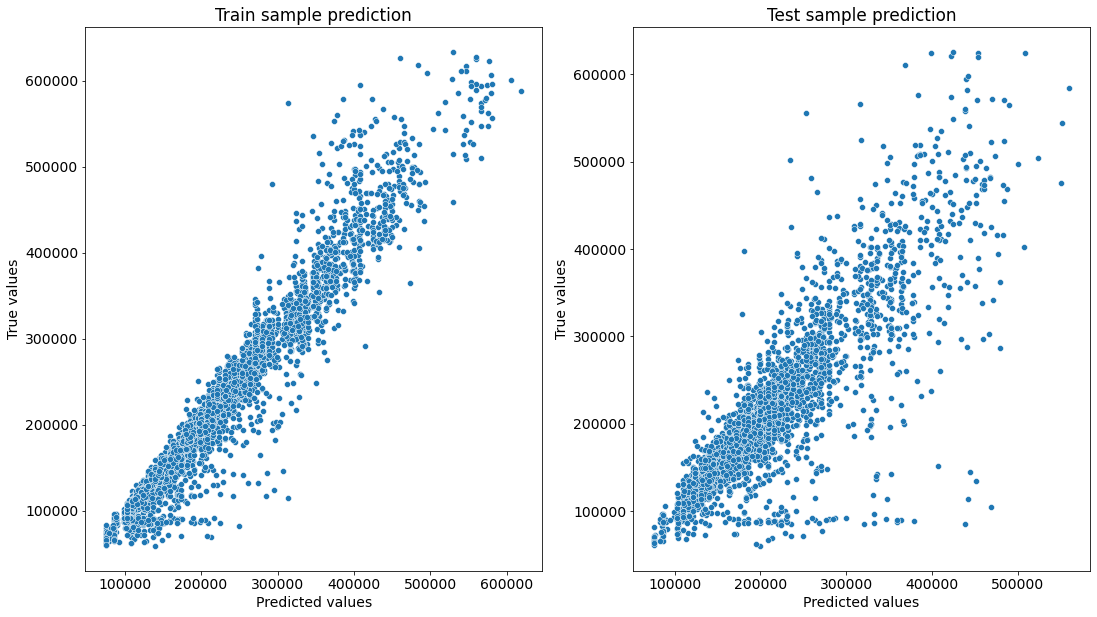

In [19]:


y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)



# VERSION 6

In [20]:
# Version 6

gbr_6 = GradientBoostingRegressor(
    criterion='mse',
    max_depth=4,
    random_state=42,  
    n_estimators=350
)

gbr_6.fit(X_train, y_train)

gbr_6.score(X_train, y_train), gbr_6.score(X_valid, y_valid)

scoreboard["Ver_6"] = [gbr_6.score(X_train, y_train), gbr_6.score(X_valid, y_valid)]

# VERSION 7

In [21]:
# Version 7

rf_model = RandomForestRegressor(random_state=21,
                                 criterion='mse',
                                 n_estimators=3000,
                                 min_samples_split=4,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=10,
                                 bootstrap=True)

gb_model = GradientBoostingRegressor(criterion='mse',
                                    min_samples_leaf=50,
                                    random_state=21,  
                                    max_features='sqrt', 
                                    loss='huber', 
                                    learning_rate=0.025,
                                    max_depth=7,                                     
                                    n_estimators=1550)     

stack = StackingRegressor([('gb',gb_model), ('rf',rf_model)])
stack.fit(X_train, y_train)
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

print(r2(y_train, y_train_preds))
print(r2(y_valid, y_test_preds))

scoreboard["Ver_7"] = [r2(y_train, y_train_preds), r2(y_valid, y_test_preds)]

0.8499034666761431
0.7545785621798602


# VERSION 8

In [22]:
# Version 8


gbr_8 = GradientBoostingRegressor(
    criterion='mse',
    max_depth=6,
    min_samples_leaf=11,
    random_state=24,
    max_features=0.5, 
    loss='huber', 
    learning_rate=0.025,
    n_estimators=1000
)

gbr_8.fit(X_train, y_train)

gbr_8.score(X_train, y_train), gbr_8.score(X_valid, y_valid)

scoreboard["Ver_8"] = [gbr_8.score(X_train, y_train), gbr_8.score(X_valid, y_valid)]

# VERSION 9

In [23]:
rand_forest = RandomForestRegressor(random_state=21, criterion='mse')

rand_forest.fit(X_train, y_train)

rand_forest.score(X_train, y_train), rand_forest.score(X_valid, y_valid)

scoreboard["Ver_9"] = [rand_forest.score(X_train, y_train), rand_forest.score(X_valid, y_valid)]

In [24]:
# Display results

df = pd.DataFrame(scoreboard)
print(df)

      Ver_1     Ver_2     Ver_3     Ver_4     Ver_6     Ver_7     Ver_8  \
0  0.812967  0.870942  0.758059  0.937849  0.888654  0.849903  0.872644   
1  0.746288  0.743326  0.706620  0.742254  0.744866  0.754579  0.756003   

      Ver_9  
0  0.961153  
1  0.730845  


# Final Step

In [25]:
# Make sure same shape as from the beginning

test_df.shape

(5000, 28)

### I will Create 8 different versions, apply all one by one in to kaggle, and the best score stays there

In [26]:
# Create Submission File Version_1 - 0.72

submit_ver1 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver1 = rand_forest.predict(test_df)

submit_ver1['Price'] = predict_ver1

submit_ver1.to_csv('submit_v1.csv', index=False)

In [27]:
# Create Submission File Version_2 - 0.73400

submit_ver2 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver2 = stack.predict(test_df)

submit_ver2['Price'] = predict_ver2

submit_ver2.to_csv('submit_v2.csv', index=False)

In [28]:
# Create Submission File Version_3 - 0.73151

submit_ver3 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver3 = gbr_8.predict(test_df)

submit_ver3['Price'] = predict_ver3

submit_ver3.to_csv('submit_v3.csv', index=False)

In [29]:
# Create Submission File Version_4 - 0.71583

submit_ver4 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver4 = gbr_6.predict(test_df)

submit_ver4['Price'] = predict_ver4

submit_ver4.to_csv('submit_v4.csv', index=False)

In [30]:
# Create Submission File Version_5 - 0.70454

submit_ver5 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver5 = gbr_4.predict(test_df)

submit_ver5['Price'] = predict_ver5

submit_ver5.to_csv('submit_v5.csv', index=False)

In [31]:
# Create Submission File Version_6 - 0.69123

submit_ver6 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver6 = gbr_3.predict(test_df)

submit_ver6['Price'] = predict_ver6

submit_ver6.to_csv('submit_v6.csv', index=False)

In [32]:
# Create Submission File Version_7 - 0.66075

submit_ver7 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver7 = gbr_2.predict(test_df)

submit_ver7['Price'] = predict_ver7

submit_ver7.to_csv('submit_v7.csv', index=False)

In [33]:
# Create Submission File Version_8 - 0.72771

submit_ver8 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver8 = gbr_1.predict(test_df)

submit_ver8['Price'] = predict_ver8

submit_ver8.to_csv('submit_v8.csv', index=False)

# Last Try

In [73]:
# Version 2

gbr_9 = GradientBoostingRegressor(
    n_estimators=500,
    max_depth=4,
    min_samples_split=5,
    learning_rate=0.01,
    loss='ls'

)
gbr_9.fit(X_train, y_train)

gbr_9.score(X_train, y_train), gbr_9.score(X_valid, y_valid)



(0.7594675196310041, 0.7022773038144217)

In [74]:
# Create Submission File Version_9

submit_ver9 = pd.read_csv(SAMPLE_SUBMISSION_PATH)

predict_ver9 = gbr_9.predict(test_df)

submit_ver9['Price'] = predict_ver9

submit_ver9.to_csv('submit_v9.csv', index=False)